In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import numpy as np
import pandas as pd


import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import dill as pickle
from tqdm import tqdm
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

from sklearn import metrics, preprocessing
import tensorflow as tf
from keras.layers import Dense, Input,Multiply,Add,Concatenate,BatchNormalization 
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers import Dropout

from catboost import CatBoostClassifier, Pool

Using TensorFlow backend.


In [2]:
with open('/kaggle/input/checkpoint2.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
train = data["train"]
test = data["test"]
del data

In [7]:
feature_importance = pd.DataFrame()

features = [c for c in train.columns if c not in ['label', 'id']]
target = train['label']
X_train, X_valid, y_train, y_valid = train_test_split(train[features], target, test_size=0.2, random_state=42)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.fit_transform(X_valid)
#X_test = scaler.fit_transform(test[features])

trn_data = Pool(data = X_train, label = y_train)
val_data = Pool(data = X_valid, label = y_valid)

model = CatBoostClassifier(task_type = "GPU",
                           devices='0',
                           random_seed = 10,
                           loss_function='MultiClass')
                           

In [8]:
fit_model = model.fit(trn_data,
                     eval_set = val_data,
                     use_best_model = True,
                     verbose = 100,
                     plot = False)

0:	learn: 4.8307784	test: 4.8364879	best: 4.8364879 (0)	total: 651ms	remaining: 10m 50s
100:	learn: 2.9378169	test: 2.9449298	best: 2.9449298 (100)	total: 1m 3s	remaining: 9m 28s
200:	learn: 2.5411362	test: 2.5382002	best: 2.5382002 (200)	total: 2m 7s	remaining: 8m 28s
300:	learn: 2.3159798	test: 2.3182551	best: 2.3182551 (300)	total: 3m 12s	remaining: 7m 27s
400:	learn: 2.1609148	test: 2.1667821	best: 2.1667821 (400)	total: 4m 18s	remaining: 6m 25s
500:	learn: 2.0321157	test: 2.0498831	best: 2.0498831 (500)	total: 5m 26s	remaining: 5m 25s
600:	learn: 1.9345546	test: 1.9788844	best: 1.9788844 (600)	total: 6m 37s	remaining: 4m 23s
700:	learn: 1.8500097	test: 1.9297994	best: 1.9297994 (700)	total: 7m 51s	remaining: 3m 20s
800:	learn: 1.7767992	test: 1.8978918	best: 1.8978918 (800)	total: 9m 4s	remaining: 2m 15s
900:	learn: 1.7104351	test: 1.8753549	best: 1.8753549 (900)	total: 10m 19s	remaining: 1m 8s
999:	learn: 1.6465979	test: 1.8595738	best: 1.8595738 (999)	total: 11m 33s	remaining: 0

In [10]:
p_valid = fit_model.predict_proba(X_valid)
yp = fit_model.predict_proba(test[features])

log_loss: 1.6668


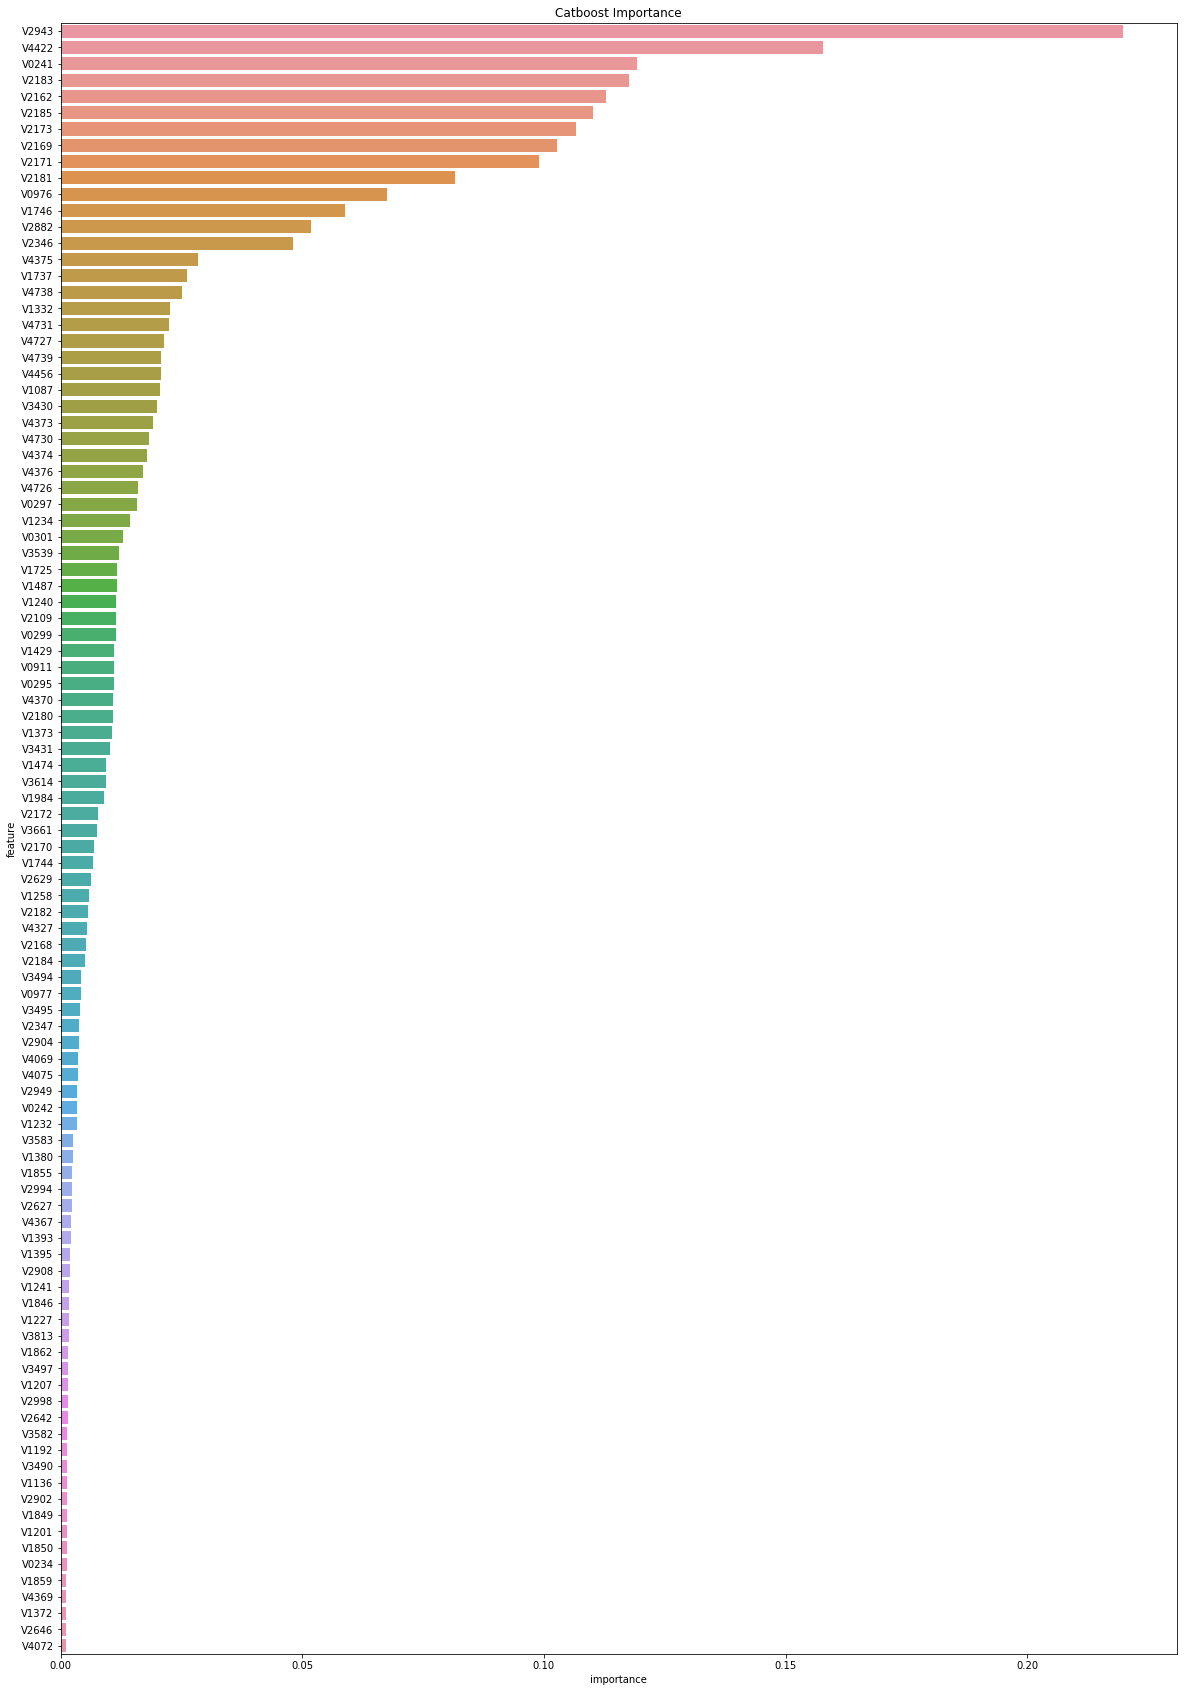

In [37]:
feature_importance["feature"] = features
feature_importance["importance"] = model.get_feature_importance(val_data,type='LossFunctionChange')
print(f'log_loss: {logloss:.5}')

In [ ]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:100].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(20, 30));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('Catboost Importance');
plt.show()

In [11]:
p_valid_df = pd.DataFrame(p_valid, columns = np.arange(198))
p_valid_df["id"] = train.id[X_valid.index].reset_index(drop = True)
p_valid_submission = p_valid_df.groupby("id").mean()

y_valid_df = pd.DataFrame(y_valid, columns = ["label"])
y_valid_df["id"] = train.id[X_valid.index].reset_index(drop = True)
y_valid_submission = y_valid_df.groupby("id").mean()

In [35]:
logloss = log_loss(y_valid_submission,p_valid_submission)

In [36]:
logloss

1.6668371341116557

In [40]:
yp_df = pd.DataFrame(yp, columns = np.arange(198))
yp_df["id"] = test.id.reset_index(drop = True)
yp_submission = yp_df.groupby("id").mean()

In [42]:
yp_submission.to_csv("submission_starter.csv")